In [1]:
%matplotlib inline
import matplotlib


In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [3]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3

In [4]:
dataset = np.load('../../car_64.npy')


1553596416


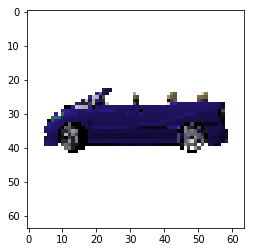

In [5]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [6]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [7]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [8]:
del dataset
dataset_train.nbytes

1242611712

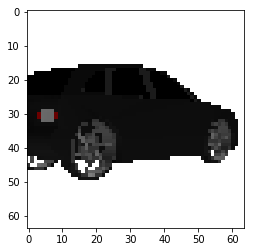

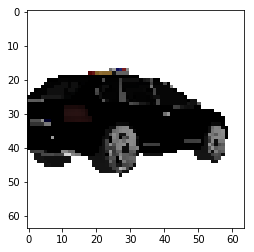

In [9]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [10]:
train_pairs = []
start_pose = range(36)

for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j == (k-3)%36:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = range(36)
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j == (k-3)%36:
                test_pairs.append((i,j,k))


In [11]:
print(train_pairs[35])
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(0, 35, 2)
(0, 35, 2)
(0, 35, 2)
(2582, 35, 2)
(592, 25, 28)


(1955, 14, 17)
(200, 35, 2)
101124


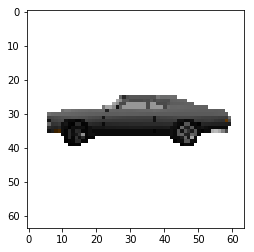

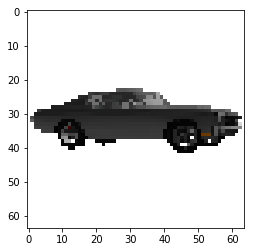

In [12]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(45*36) + 27]
j = dataset_train[(45*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [13]:
def normalize(data):
    data *= 2.0
    data /= 255.0
    data -= 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [14]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

1


In [15]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        #print(p[1],p[2])
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
#         cur_pose =  np.zeros(36, dtype='uint8')
#         cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
#         pose.append(np.broadcast_to(cur_pose,(8,8,36)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
#     pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels

batch, batch_labels = get_batch_data(train_pairs[36:72])

(36, 64, 64, 3) (36, 64, 64, 3)
<class 'numpy.float64'>
1.0 -1.0


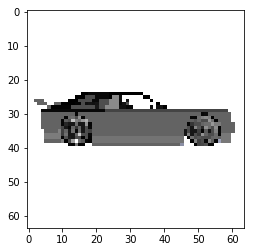

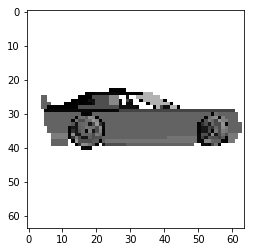

In [16]:
print(batch.shape, batch_labels.shape)

t = 22
#print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [17]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [18]:
#definition of my layers


# def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=None):
#     #act = tf.nn.leaky_relu
#     with tf.variable_scope(scope_name):
#         return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
#          biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))

def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )
    
def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss


In [19]:


batch_size = 36
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")

In [20]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Conv + relu  + Conv + relu  
# After 3 Convolution ,we will have a latent space
#ae_reuse= False
def AutoEncoder(inputs_):

    with tf.variable_scope('encoder'):
        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = conv2d(_, output=96 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=None)
        _ = tf.nn.tanh(_)
    return _
        


In [21]:
global_step = tf.Variable(0,trainable=False)
learning_rate = 5e-4
decay_steps = 1000
decay_rate = 0.96

In [22]:
#calculate loss
tanh6 = AutoEncoder(inputs_)
loss_op = l1_loss(tanh6,targets_)

#Optimizer
# global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)

Step 1000: loss = 0.1580
Step 2000: loss = 0.1619
Epoch 0: loss = 0.1487


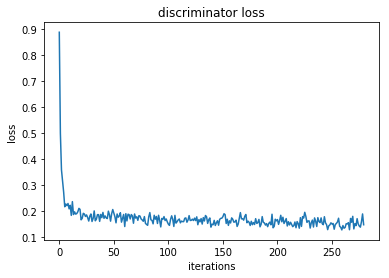

Step 3000: loss = 0.1385
Step 4000: loss = 0.1580
Step 5000: loss = 0.1413
Epoch 1: loss = 0.1396


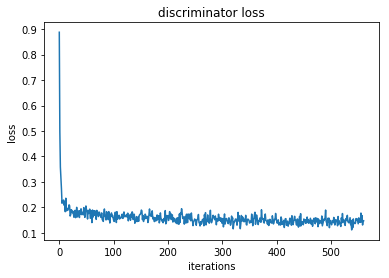

Step 6000: loss = 0.1462
Step 7000: loss = 0.1195
Step 8000: loss = 0.1325
Epoch 2: loss = 0.1347


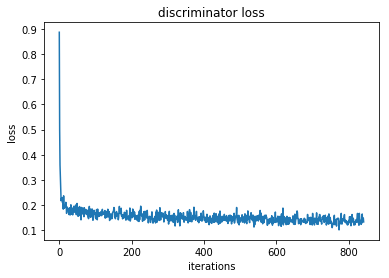

Step 9000: loss = 0.1294
Step 10000: loss = 0.1368
Step 11000: loss = 0.1351
Epoch 3: loss = 0.1313


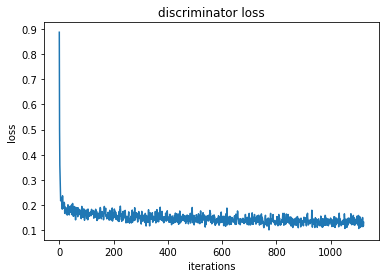

Step 12000: loss = 0.1542
Step 13000: loss = 0.1211
Step 14000: loss = 0.1304
Epoch 4: loss = 0.1282


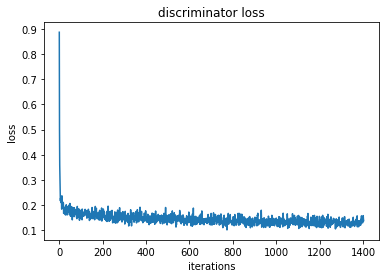

Step 15000: loss = 0.1177
Step 16000: loss = 0.1232
Epoch 5: loss = 0.1259


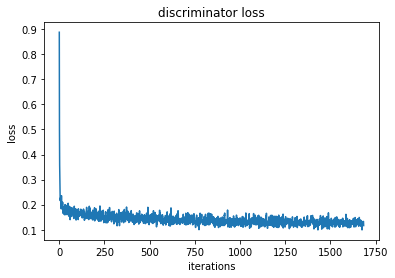

Step 17000: loss = 0.1245
Step 18000: loss = 0.1302
Step 19000: loss = 0.1313
Epoch 6: loss = 0.1246


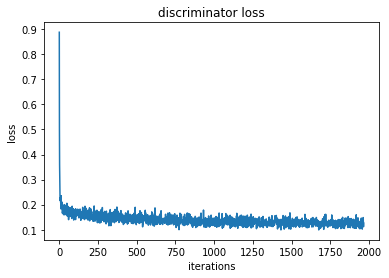

Step 20000: loss = 0.1249
Step 21000: loss = 0.1229
Step 22000: loss = 0.1183
Epoch 7: loss = 0.1231


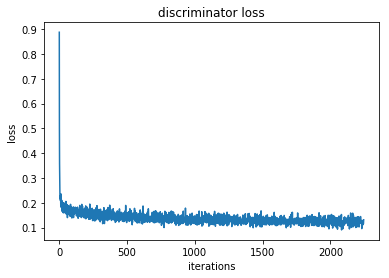

Step 23000: loss = 0.1105
Step 24000: loss = 0.1293
Step 25000: loss = 0.1074
Epoch 8: loss = 0.1219


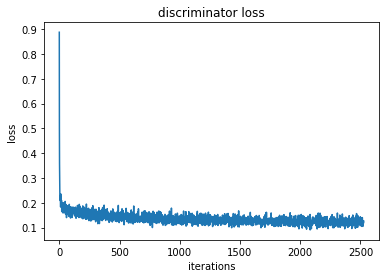

Step 26000: loss = 0.1367
Step 27000: loss = 0.1182
Step 28000: loss = 0.1072
Epoch 9: loss = 0.1208


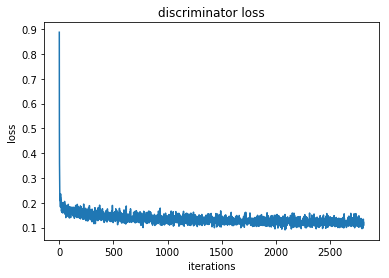

Step 29000: loss = 0.1020
Step 30000: loss = 0.1136
Epoch 10: loss = 0.1195


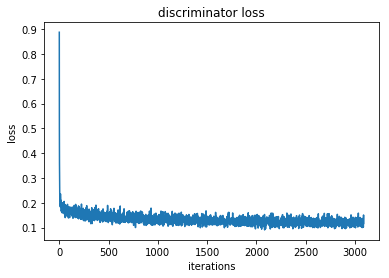

Step 31000: loss = 0.1324
Step 32000: loss = 0.1150
Step 33000: loss = 0.1630
Epoch 11: loss = 0.1190


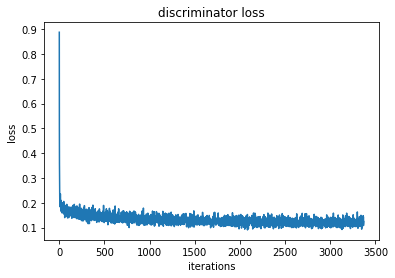

Step 34000: loss = 0.1252
Step 35000: loss = 0.1195
Step 36000: loss = 0.1179
Epoch 12: loss = 0.1181


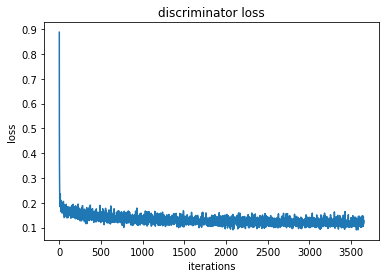

Step 37000: loss = 0.0962
Step 38000: loss = 0.1084
Step 39000: loss = 0.1267
Epoch 13: loss = 0.1176


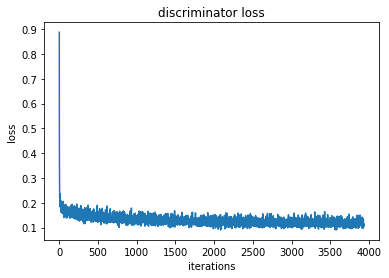

Step 40000: loss = 0.1272
Step 41000: loss = 0.1392
Step 42000: loss = 0.1268
Epoch 14: loss = 0.1170


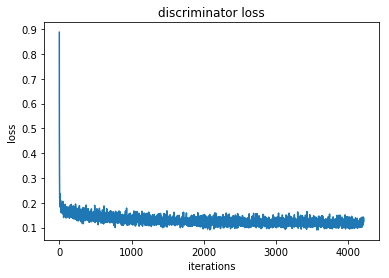

Step 43000: loss = 0.1218
Step 44000: loss = 0.1197
Epoch 15: loss = 0.1168


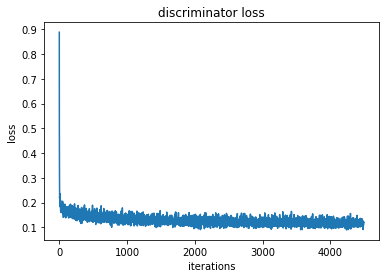

Step 45000: loss = 0.1090
Step 46000: loss = 0.1082
Step 47000: loss = 0.1159
Epoch 16: loss = 0.1159


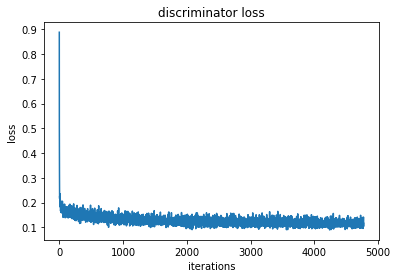

Step 48000: loss = 0.0876
Step 49000: loss = 0.1088
Step 50000: loss = 0.1127
Epoch 17: loss = 0.1149


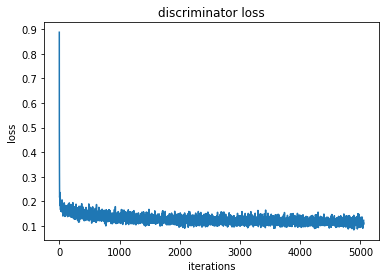

Step 51000: loss = 0.1259
Step 52000: loss = 0.1014
Step 53000: loss = 0.1163
Epoch 18: loss = 0.1142


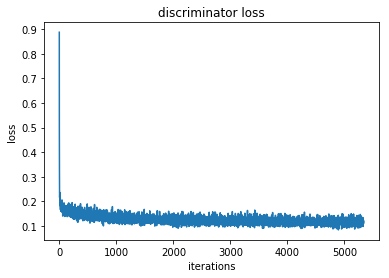

Step 54000: loss = 0.1221
Step 55000: loss = 0.1320
Step 56000: loss = 0.1107
Epoch 19: loss = 0.1137


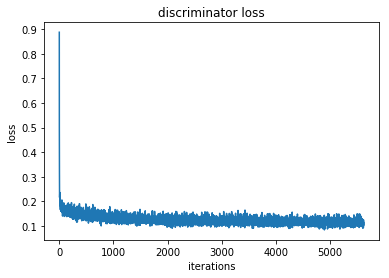

Step 57000: loss = 0.0962
Step 58000: loss = 0.1070
Epoch 20: loss = 0.1133


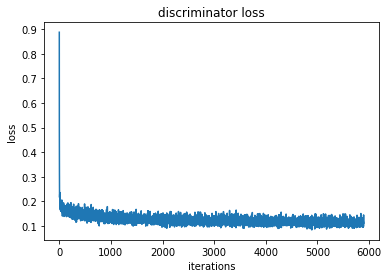

Step 59000: loss = 0.1061
Step 60000: loss = 0.1104
Step 61000: loss = 0.1219
Epoch 21: loss = 0.1132


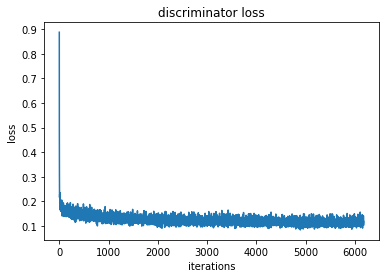

Step 62000: loss = 0.1192
Step 63000: loss = 0.0989
Step 64000: loss = 0.1033
Epoch 22: loss = 0.1129


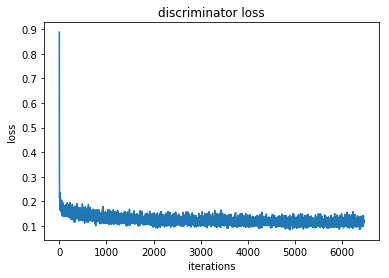

Step 65000: loss = 0.0929
Step 66000: loss = 0.1358
Step 67000: loss = 0.1162
Epoch 23: loss = 0.1123


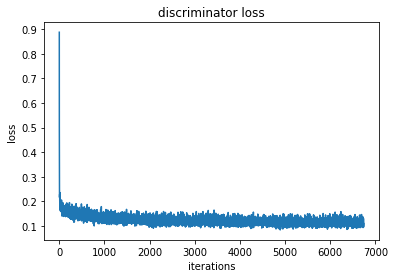

Step 68000: loss = 0.1002
Step 69000: loss = 0.1032
Step 70000: loss = 0.1137
Epoch 24: loss = 0.1120


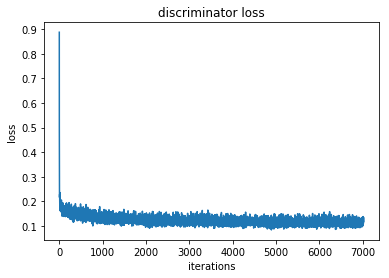

Step 71000: loss = 0.1181
Step 72000: loss = 0.1029
Step 73000: loss = 0.1142
Epoch 25: loss = 0.1112


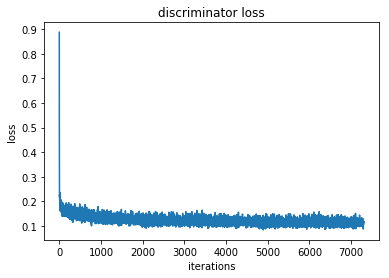

Step 74000: loss = 0.1090
Step 75000: loss = 0.1089
Epoch 26: loss = 0.1112


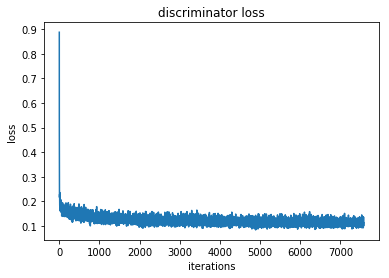

Step 76000: loss = 0.1274
Step 77000: loss = 0.1224
Step 78000: loss = 0.1081
Epoch 27: loss = 0.1108


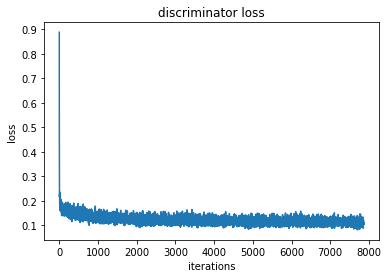

Step 79000: loss = 0.1126
Step 80000: loss = 0.1160
Step 81000: loss = 0.1053
Epoch 28: loss = 0.1105


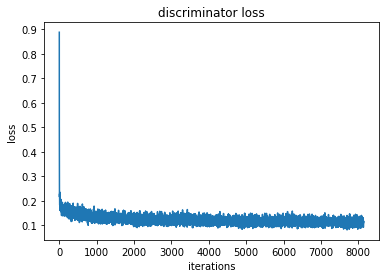

Step 82000: loss = 0.1279
Step 83000: loss = 0.1025
Step 84000: loss = 0.0987
Epoch 29: loss = 0.1101


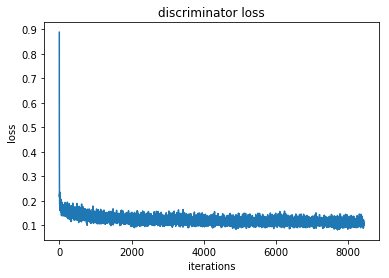

Step 85000: loss = 0.1102
Step 86000: loss = 0.1077
Step 87000: loss = 0.1084
Epoch 30: loss = 0.1101


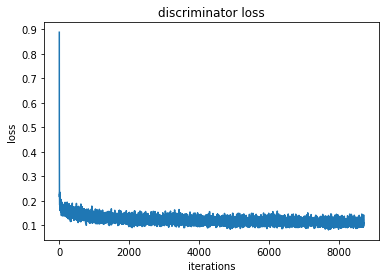

Step 88000: loss = 0.1474
Step 89000: loss = 0.1263
Epoch 31: loss = 0.1100


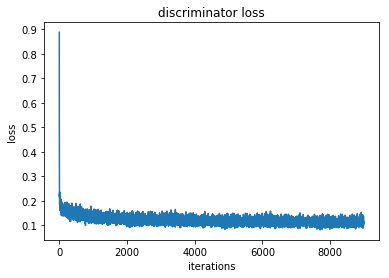

Step 90000: loss = 0.1184
Step 91000: loss = 0.1062
Step 92000: loss = 0.1193
Epoch 32: loss = 0.1098


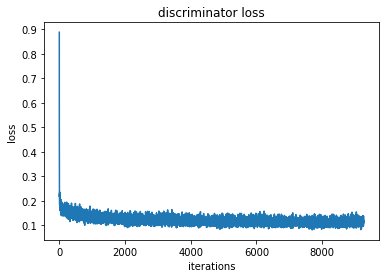

Step 93000: loss = 0.1174
Step 94000: loss = 0.0958
Step 95000: loss = 0.1193
Epoch 33: loss = 0.1095


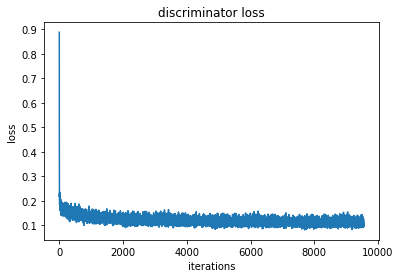

Step 96000: loss = 0.1105
Step 97000: loss = 0.1117
Step 98000: loss = 0.1141
Epoch 34: loss = 0.1093


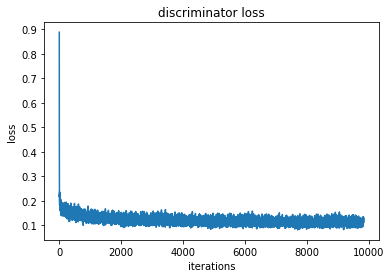

Step 99000: loss = 0.1059
Step 100000: loss = 0.1099
Step 101000: loss = 0.1130
Epoch 35: loss = 0.1090


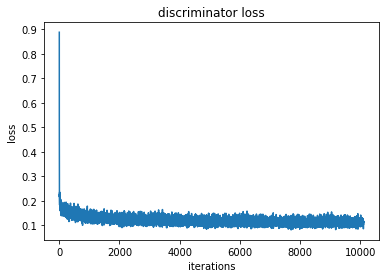

Step 102000: loss = 0.1025
Step 103000: loss = 0.1078
Epoch 36: loss = 0.1088


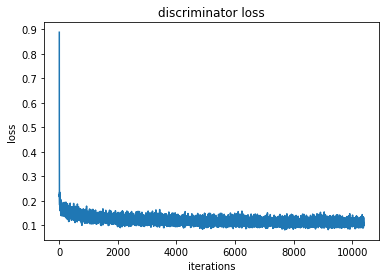

Step 104000: loss = 0.1139
Step 105000: loss = 0.1106
Step 106000: loss = 0.1124
Epoch 37: loss = 0.1086


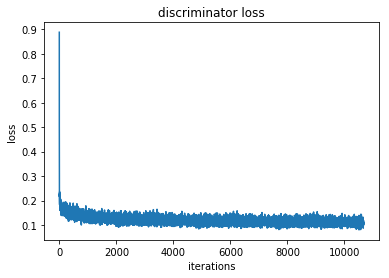

Step 107000: loss = 0.1021
Step 108000: loss = 0.1035
Step 109000: loss = 0.1277
Epoch 38: loss = 0.1085


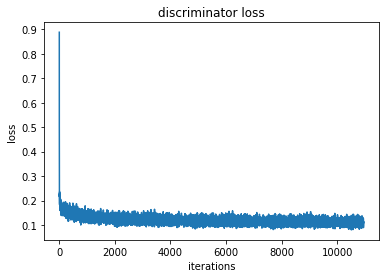

Step 110000: loss = 0.1126
Step 111000: loss = 0.1327
Step 112000: loss = 0.1147
Epoch 39: loss = 0.1088


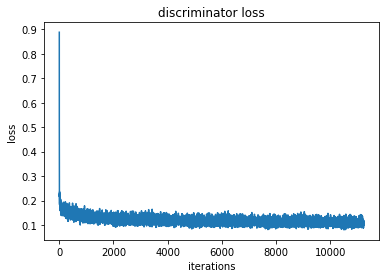

Step 113000: loss = 0.1189
Step 114000: loss = 0.0977
Step 115000: loss = 0.1118
Epoch 40: loss = 0.1084


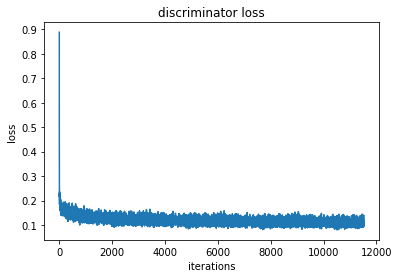

Step 116000: loss = 0.1193
Step 117000: loss = 0.1060
Epoch 41: loss = 0.1082


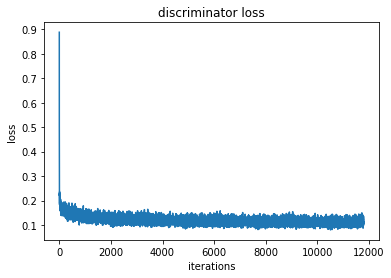

Step 118000: loss = 0.1224
Step 119000: loss = 0.1005
Step 120000: loss = 0.0996
Epoch 42: loss = 0.1079


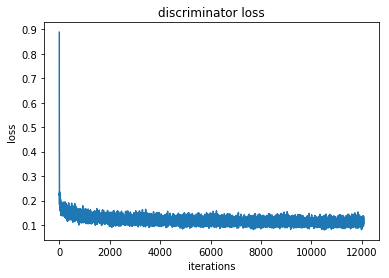

Step 121000: loss = 0.0978
Step 122000: loss = 0.1016
Step 123000: loss = 0.0955
Epoch 43: loss = 0.1082


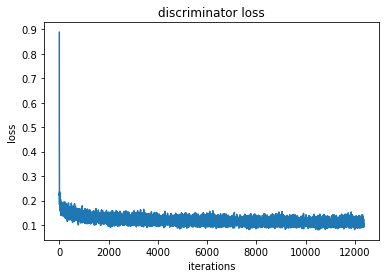

Step 124000: loss = 0.1153
Step 125000: loss = 0.1126
Step 126000: loss = 0.1058
Epoch 44: loss = 0.1083


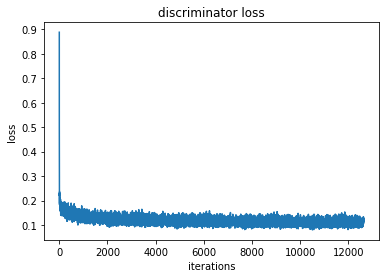

Step 127000: loss = 0.1020
Step 128000: loss = 0.1084
Step 129000: loss = 0.1197
Epoch 45: loss = 0.1084


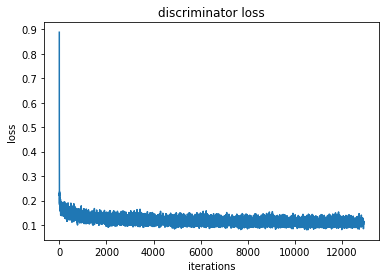

Step 130000: loss = 0.1046
Step 131000: loss = 0.1114
Step 132000: loss = 0.1069
Epoch 46: loss = 0.1082


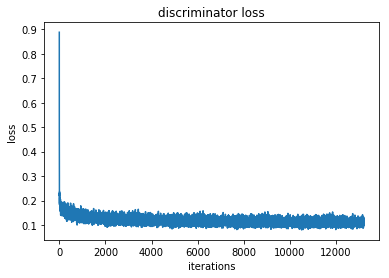

Step 133000: loss = 0.1020
Step 134000: loss = 0.1100
Epoch 47: loss = 0.1085


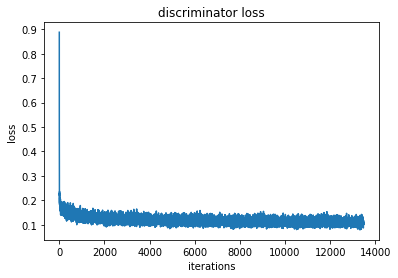

Step 135000: loss = 0.1043
Step 136000: loss = 0.1162
Step 137000: loss = 0.0939
Epoch 48: loss = 0.1084


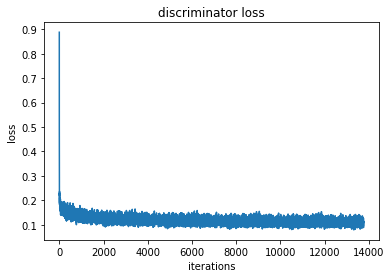

Step 138000: loss = 0.1090
Step 139000: loss = 0.1208
Step 140000: loss = 0.0934
Epoch 49: loss = 0.1082


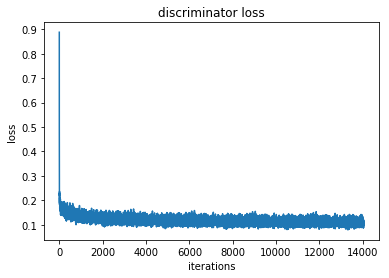

Step 141000: loss = 0.1042
Step 142000: loss = 0.1110
Step 143000: loss = 0.1075
Epoch 50: loss = 0.1083


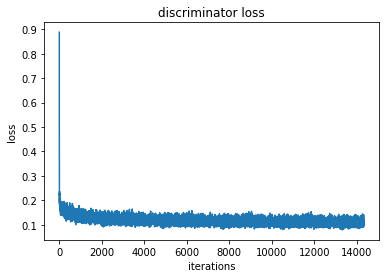

Step 144000: loss = 0.1247
Step 145000: loss = 0.1087
Step 146000: loss = 0.1061
Epoch 51: loss = 0.1081


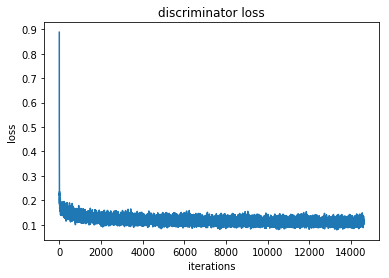

Step 147000: loss = 0.1116
Step 148000: loss = 0.0807
Epoch 52: loss = 0.1082


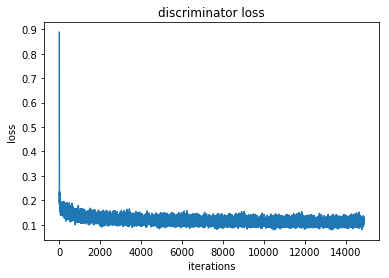

Step 149000: loss = 0.1103
Step 150000: loss = 0.1044
Step 151000: loss = 0.1075
Epoch 53: loss = 0.1079


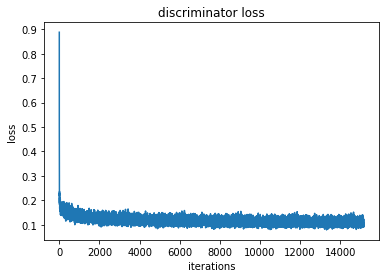

Step 152000: loss = 0.1019
Step 153000: loss = 0.1211
Step 154000: loss = 0.1055
Epoch 54: loss = 0.1081


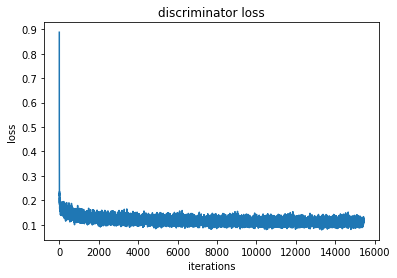

Step 155000: loss = 0.1084
Step 156000: loss = 0.0935
Step 157000: loss = 0.1150
Epoch 55: loss = 0.1080


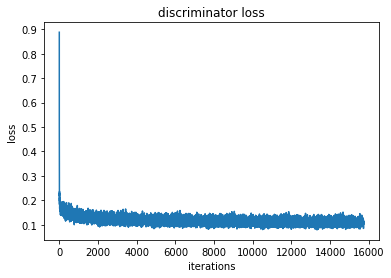

Step 158000: loss = 0.1184
Step 159000: loss = 0.1053
Step 160000: loss = 0.1027
Epoch 56: loss = 0.1080


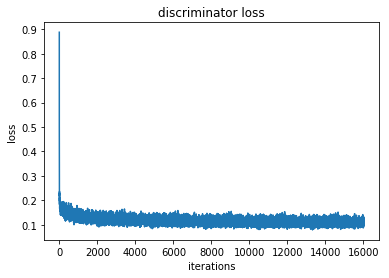

Step 161000: loss = 0.1119
Step 162000: loss = 0.1155
Epoch 57: loss = 0.1077


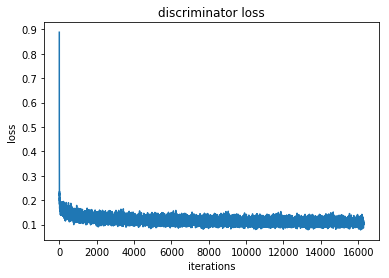

Step 163000: loss = 0.1065
Step 164000: loss = 0.1089
Step 165000: loss = 0.1033
Epoch 58: loss = 0.1074


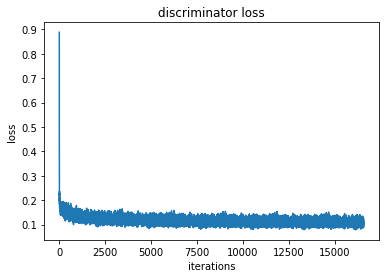

Step 166000: loss = 0.0997
Step 167000: loss = 0.1032
Step 168000: loss = 0.1052
Epoch 59: loss = 0.1076


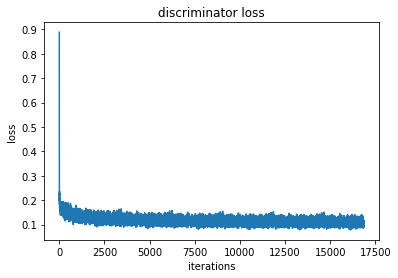

Step 169000: loss = 0.1166
Step 170000: loss = 0.1076
Step 171000: loss = 0.0994
Epoch 60: loss = 0.1071


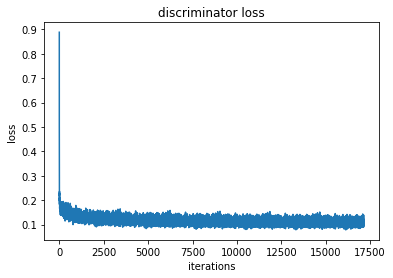

Step 172000: loss = 0.1000
Step 173000: loss = 0.1020
Step 174000: loss = 0.1111
Epoch 61: loss = 0.1072


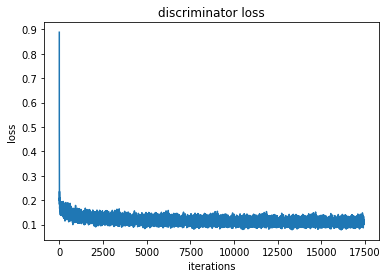

Step 175000: loss = 0.1149
Step 176000: loss = 0.1292
Epoch 62: loss = 0.1072


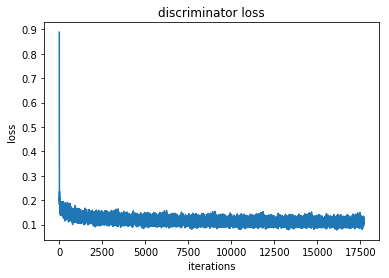

Step 177000: loss = 0.1032
Step 178000: loss = 0.1019
Step 179000: loss = 0.1030
Epoch 63: loss = 0.1074


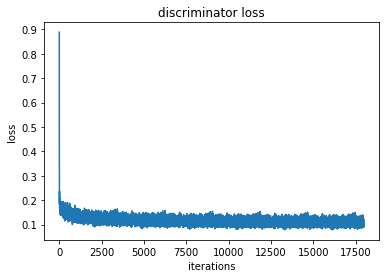

Step 180000: loss = 0.1080
Step 181000: loss = 0.1054
Step 182000: loss = 0.0944
Epoch 64: loss = 0.1074


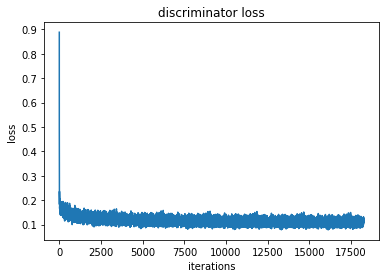

Step 183000: loss = 0.1336
Step 184000: loss = 0.1115
Step 185000: loss = 0.1114
Epoch 65: loss = 0.1073


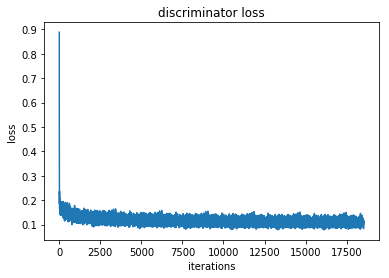

Step 186000: loss = 0.1167
Step 187000: loss = 0.1029
Step 188000: loss = 0.1072
Epoch 66: loss = 0.1073


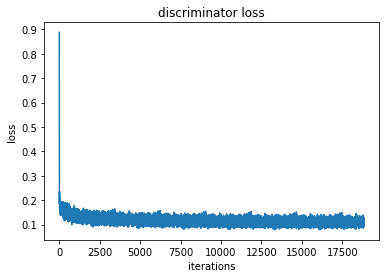

Step 189000: loss = 0.1241
Step 190000: loss = 0.1089
Step 191000: loss = 0.1053
Epoch 67: loss = 0.1068


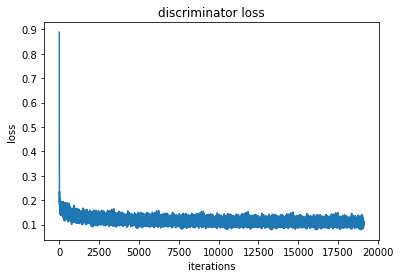

Step 192000: loss = 0.1043
Step 193000: loss = 0.1155
Epoch 68: loss = 0.1073


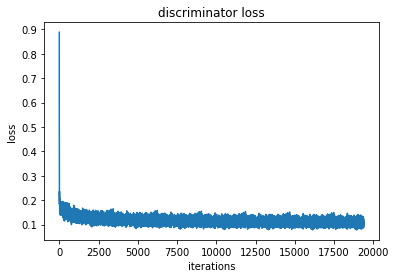

Step 194000: loss = 0.0987
Step 195000: loss = 0.0962
Step 196000: loss = 0.1132
Epoch 69: loss = 0.1071


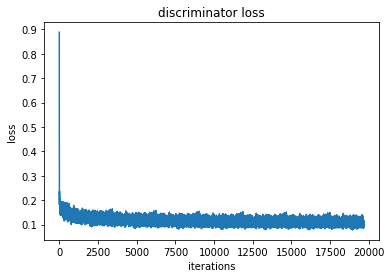

Step 197000: loss = 0.1066
Step 198000: loss = 0.0966
Step 199000: loss = 0.1025
Epoch 70: loss = 0.1074


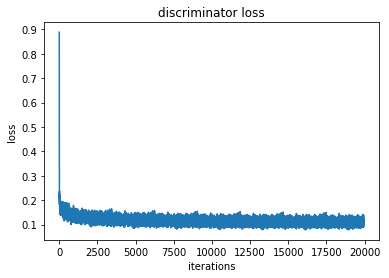

Step 200000: loss = 0.1084
Step 201000: loss = 0.0951
Step 202000: loss = 0.0975
Epoch 71: loss = 0.1071


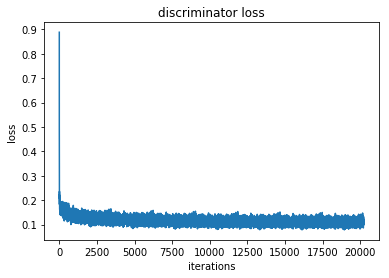

Step 203000: loss = 0.1117
Step 204000: loss = 0.1110
Step 205000: loss = 0.1043
Epoch 72: loss = 0.1073


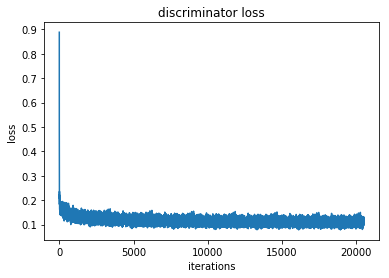

Step 206000: loss = 0.1119
Step 207000: loss = 0.1170
Epoch 73: loss = 0.1070


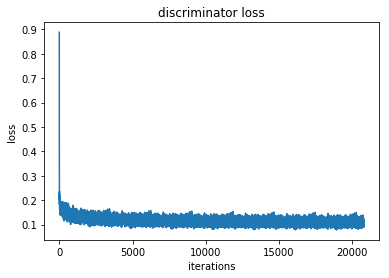

Step 208000: loss = 0.1038
Step 209000: loss = 0.0965
Step 210000: loss = 0.1169
Epoch 74: loss = 0.1072


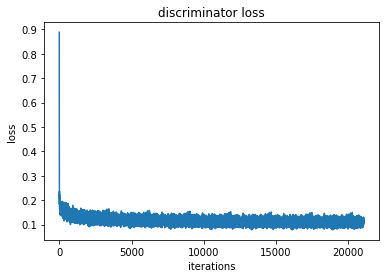

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses = []
epochs = 75
total_images = len(train_pairs)
step = 0

r = total_images // batch_size

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        
        pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels = get_batch_data(pairs)
        
        feed_dict = {inputs_: batch, targets_: batch_labels}
        _, loss = sess.run([train_op, loss_op], feed_dict = feed_dict)
        if step %10 == 0:
            losses.append(loss)
        
        if step % 1000 == 0:
            print('Step {0}: loss = {1:.4f}'.format(step, loss))
            
    print('Epoch {0}: loss = {1:.4f}'.format(epoch, loss))
    plt.plot(losses)
    plt.title('discriminator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [65]:
t_pairs = test_pairs[450 * batch_size : 451 * batch_size]
print (len(test_pairs))
test_batch, test_labels = get_batch_data(t_pairs, False)

25308


In [66]:
feed_dict = { inputs_: test_batch}
op = sess.run([tanh6], feed_dict = feed_dict)

In [67]:
j = 20
op = denormalize(op[0])

In [68]:
print(np.min(op), np.max(op))

0.000478774 255.0


In [69]:
op = np.where(op < 0.0,0.0, op)

In [70]:
print(np.min(op), np.max(op))

0.000478774 255.0


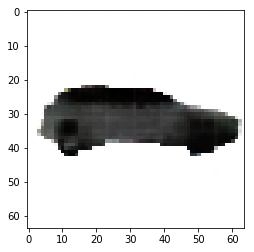

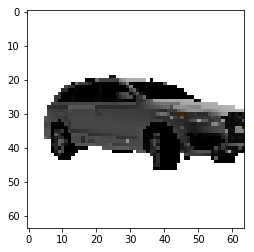

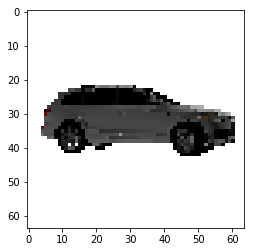

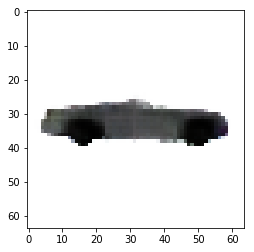

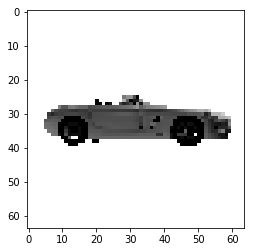

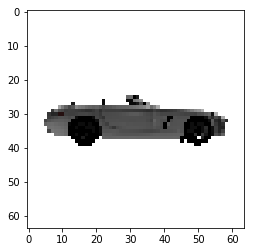

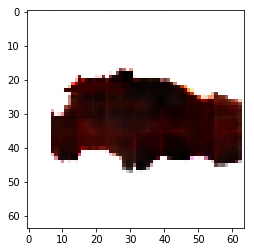

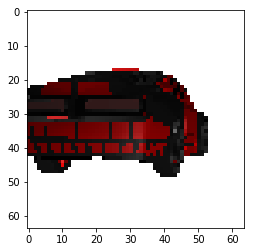

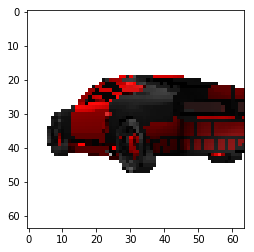

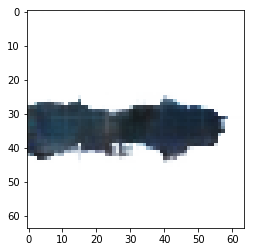

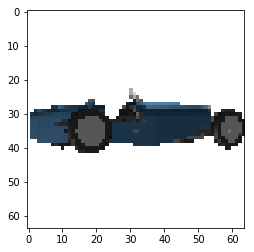

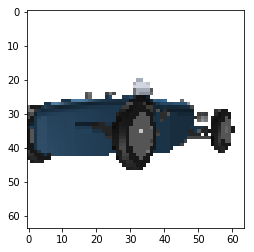

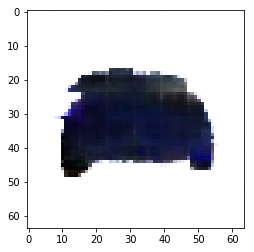

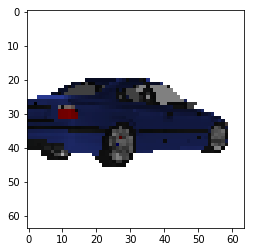

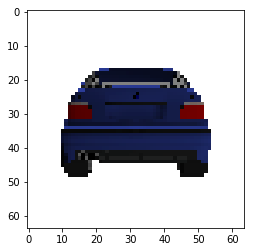

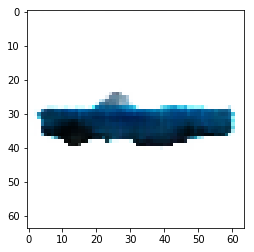

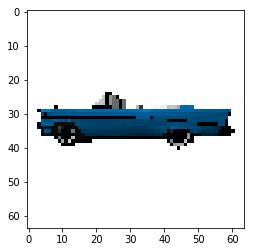

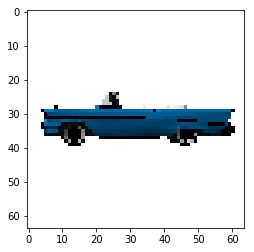

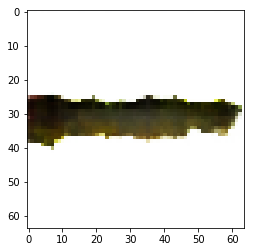

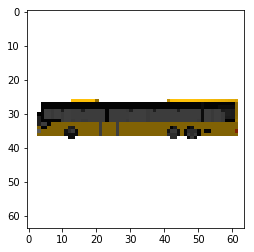

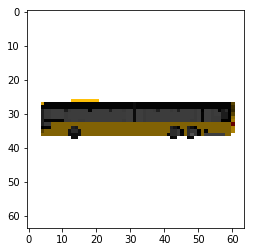

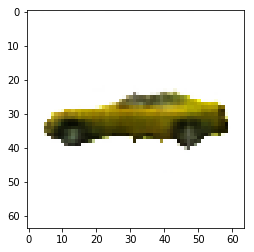

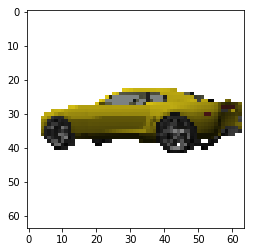

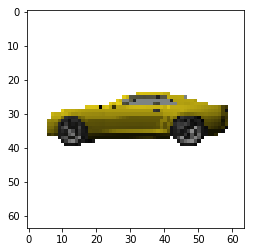

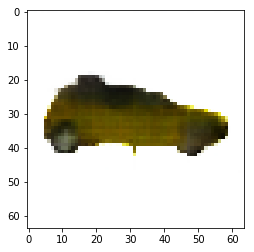

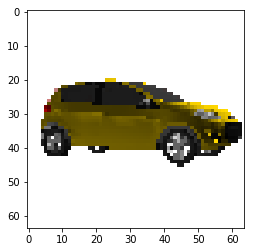

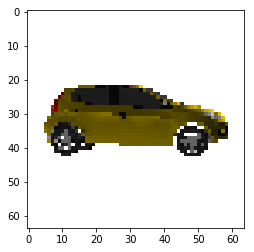

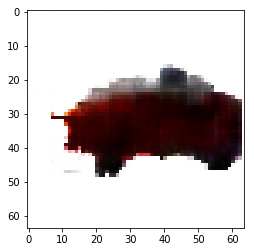

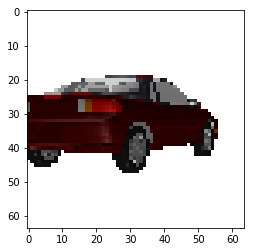

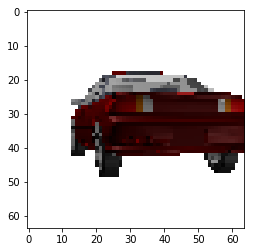

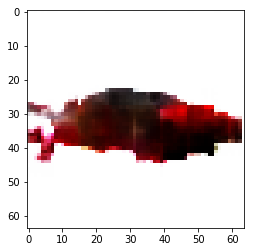

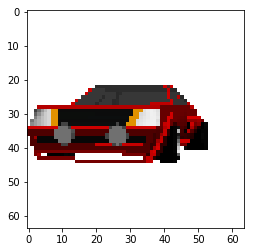

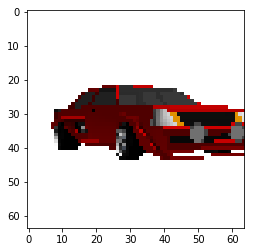

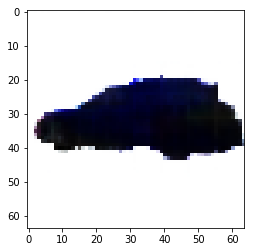

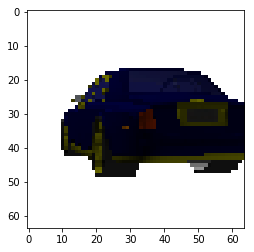

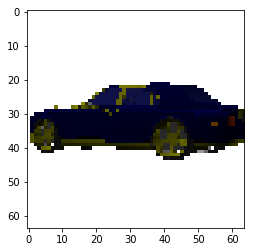

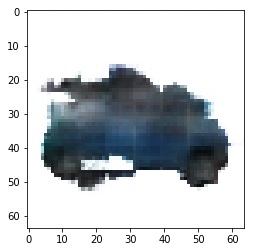

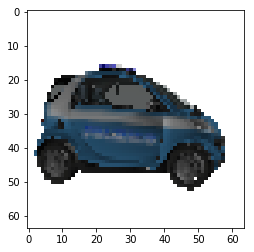

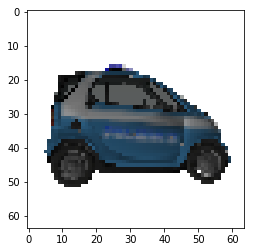

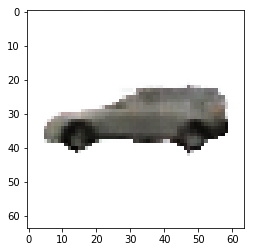

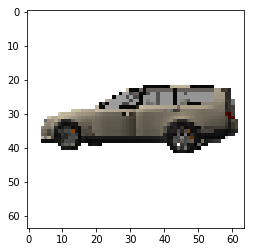

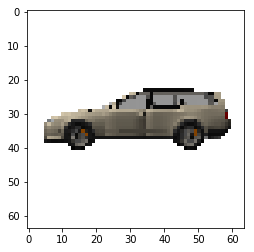

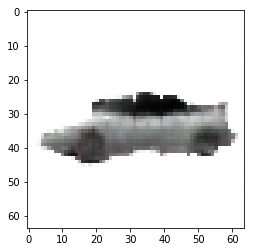

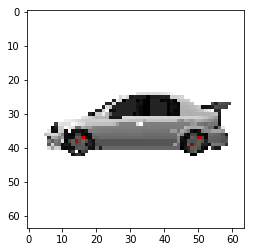

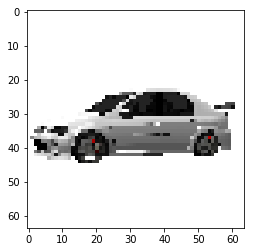

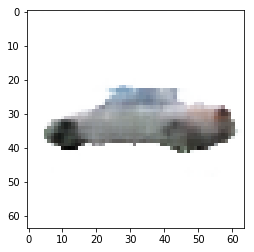

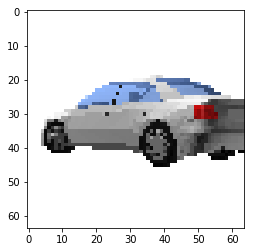

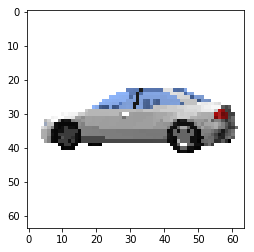

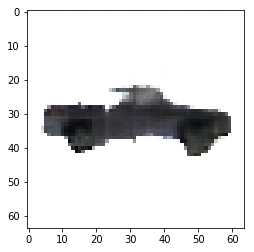

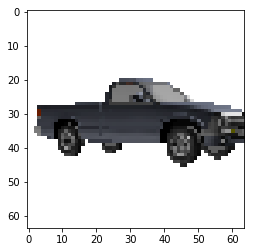

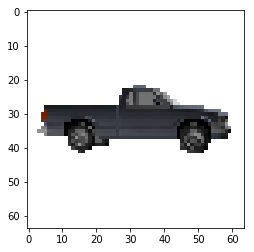

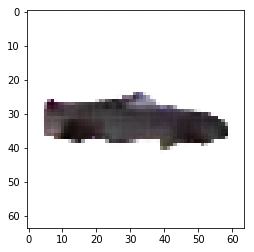

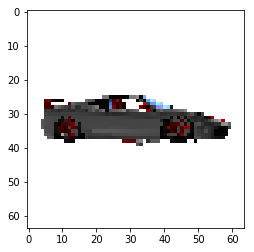

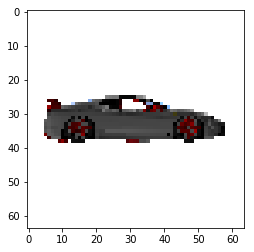

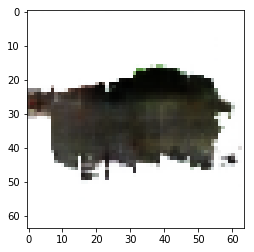

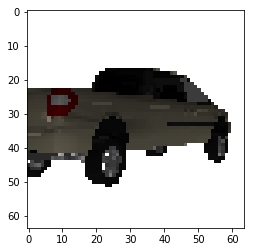

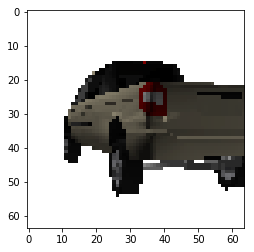

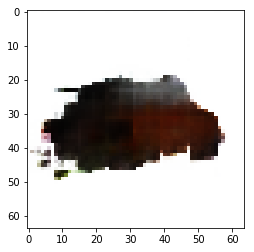

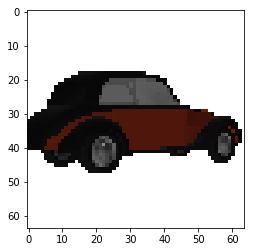

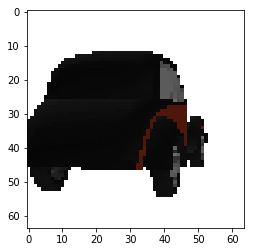

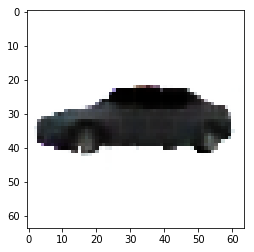

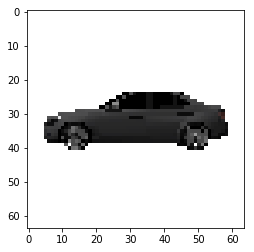

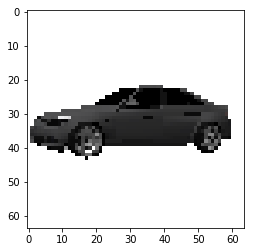

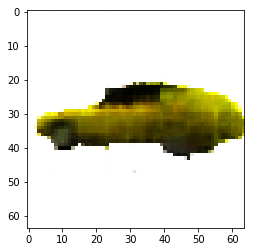

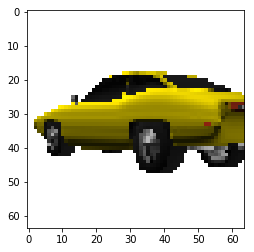

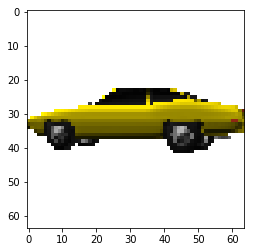

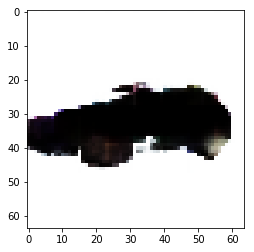

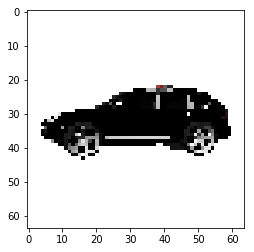

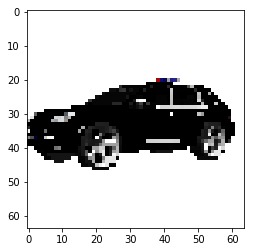

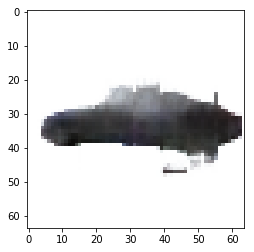

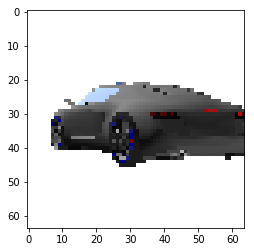

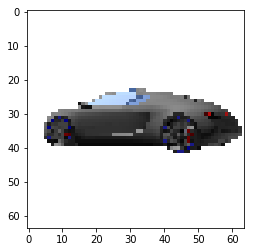

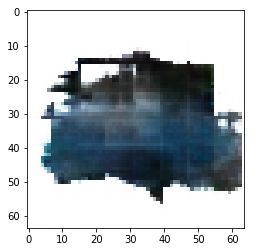

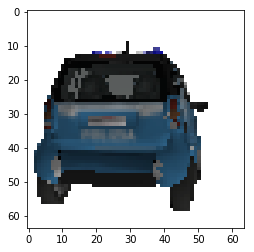

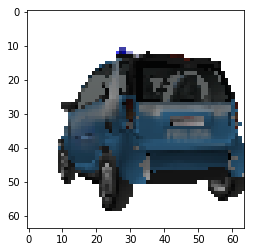

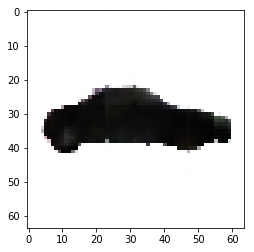

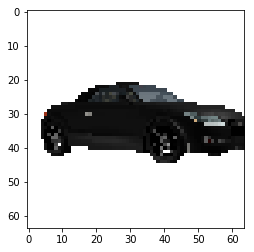

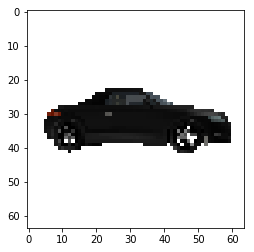

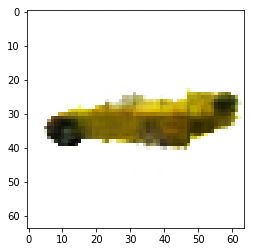

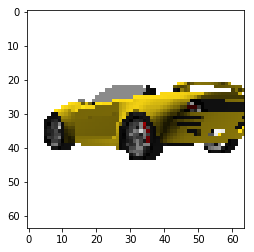

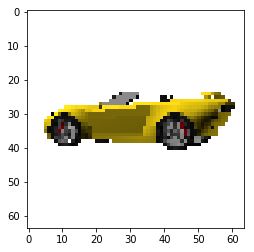

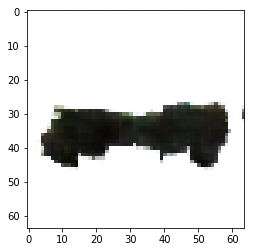

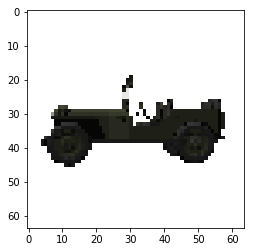

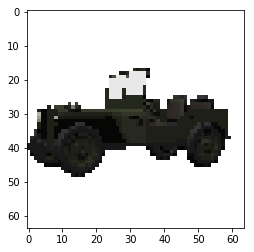

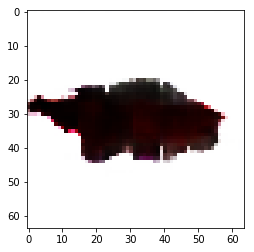

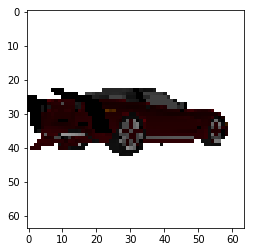

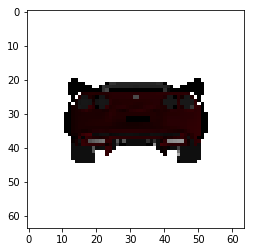

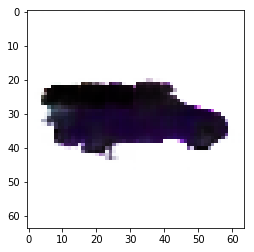

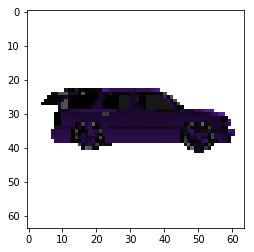

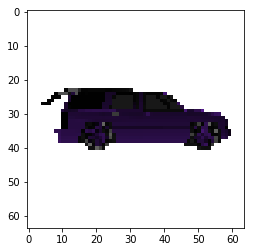

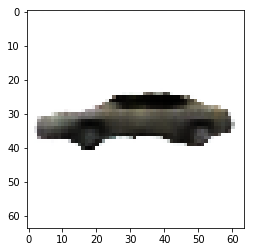

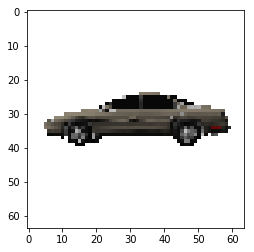

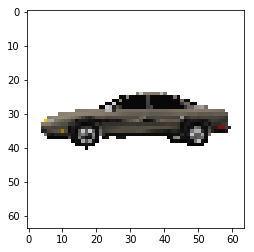

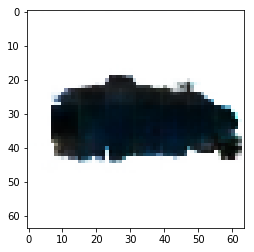

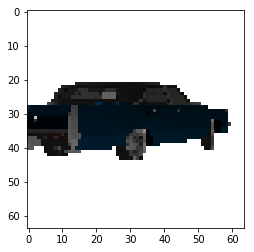

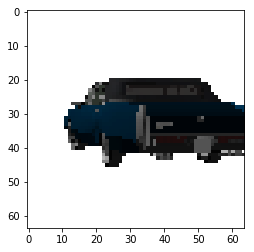

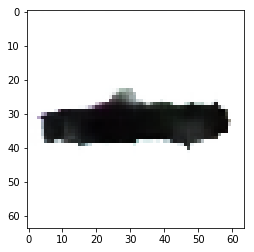

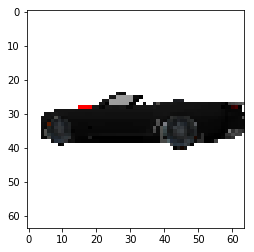

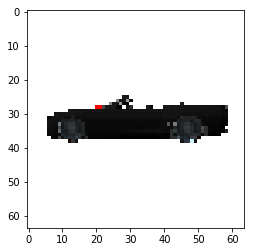

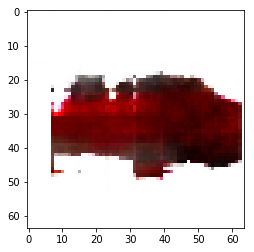

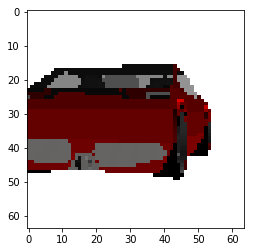

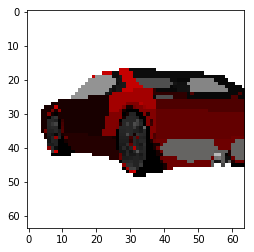

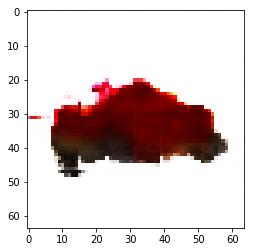

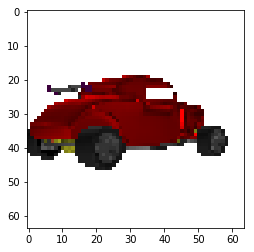

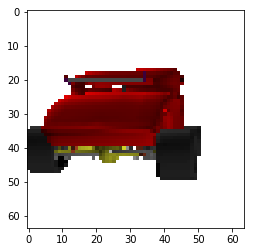

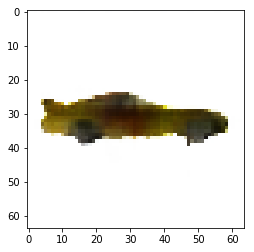

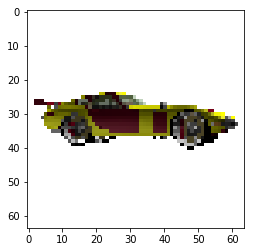

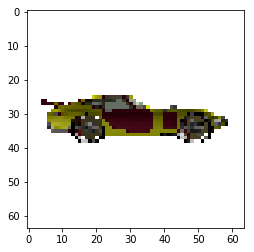

In [71]:
for j in range(batch_size):
    f = "batch_451_output" + str(j) + '.png'
    tmp = op[j]
    misc.imsave(f, tmp/255)
    plt.imshow(tmp / 255)
    plt.show()
    
    f1 = "batch_451_orig_image" + str(j) + '.png'
    misc.imsave(f1, denormalize(test_batch[j])/255)
    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    f2 = "batch_451_ground_truth" + str(j) + '.png'
    misc.imsave(f2, denormalize(test_labels[j])/255)  
    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()